In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Lambda, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import os
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K

In [3]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/CAPSTONE-PROJECT/data/aug'

In [28]:
# Hyperparameters
img_width, img_height = 128, 128
batch_size = 8
epochs = 50
learning_rate = 0.01

In [29]:
# Fungsi untuk memuat gambar dan resize
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Membaca gambar grayscale
    img = cv2.resize(img, (img_width, img_height))  # Resize gambar
    img = img.astype('float32') / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=-1)  # Menambahkan dimensi channel
    return img

In [6]:
# Membuat pasangan gambar positif dan negatif
def make_pairs(image_paths, labels):
    pairs = []
    pair_labels = []
    label_to_indices = {}

    # Membuat mapping dari label ke indeks
    for idx, label in enumerate(labels):
        if label in label_to_indices:
            label_to_indices[label].append(idx)
        else:
            label_to_indices[label] = [idx]

    unique_labels = list(label_to_indices.keys())
    num_classes = len(unique_labels)

    print(f'Unique labels: {unique_labels}')
    print(f'Number of classes: {num_classes}')

    for label in unique_labels:
        indices = label_to_indices[label]
        # Membuat pasangan positif
        for i in range(len(indices) - 1):
            img1 = load_image(image_paths[indices[i]])
            img2 = load_image(image_paths[indices[i + 1]])
            print(f'Positive Pair: {image_paths[indices[i]]} - {image_paths[indices[i + 1]]}')
            pairs.append([img1, img2])
            pair_labels.append(1)

            # Membuat pasangan negatif
            neg_label = np.random.choice(
                [l for l in unique_labels if l != label]
            )
            neg_indices = label_to_indices[neg_label]
            neg_img = load_image(image_paths[np.random.choice(neg_indices)])
            print(f'Negative Pair: {image_paths[indices[i]]} - {image_paths[np.random.choice(neg_indices)]}')
            print("-------------------------------")
            pairs.append([img1, neg_img])
            pair_labels.append(0)

        print("Pair labels: ", pair_labels)

    return np.array(pairs), np.array(pair_labels)

In [7]:
# Fungsi untuk memuat data dan label
def data_loader(data_dir):
    image_paths = []
    labels = []

    for class_dir in os.listdir(data_dir):
        class_dir_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_dir_path):
            for img_name in os.listdir(class_dir_path):
                img_path = os.path.join(class_dir_path, img_name)
                image_paths.append(img_path)
                labels.append(class_dir)

    return np.array(image_paths), np.array(labels)

In [8]:
def build_siamese_model(input_shape):
    input = Input(shape=input_shape)

    # Feature extraction layers (CNN)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    embedding = Dense(128)(x)  # Embedding layer

    # Normalize embeddings
    embedding = Lambda(lambda x: K.l2_normalize(x, axis=-1), output_shape=(128,))(embedding)



    model = Model(inputs=input, outputs=embedding)

     # Define the learning rate reduction callback
    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=2,
        verbose=1,
        factor=0.7,
        min_lr=1e-10
    )

    return model, learning_rate_reduction

In [9]:
# Fungsi untuk menghitung jarak Euclidean
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sum_square = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [10]:
# Contrastive loss
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [11]:
# Custom accuracy metric
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [12]:
# Load dataset and create pairs
image_paths, labels = data_loader(data_dir)
pairs, pair_labels = make_pairs(image_paths, labels)

Unique labels: ['person_001', 'person_002', 'person_003', 'person_004']
Number of classes: 4
Positive Pair: /content/drive/MyDrive/Colab Notebooks/CAPSTONE-PROJECT/data/aug/person_001/data_001_1.jpg - /content/drive/MyDrive/Colab Notebooks/CAPSTONE-PROJECT/data/aug/person_001/data_001_10.jpg
Negative Pair: /content/drive/MyDrive/Colab Notebooks/CAPSTONE-PROJECT/data/aug/person_001/data_001_1.jpg - /content/drive/MyDrive/Colab Notebooks/CAPSTONE-PROJECT/data/aug/person_002/data_002_8.jpg
-------------------------------
Positive Pair: /content/drive/MyDrive/Colab Notebooks/CAPSTONE-PROJECT/data/aug/person_001/data_001_10.jpg - /content/drive/MyDrive/Colab Notebooks/CAPSTONE-PROJECT/data/aug/person_001/data_001_11.jpg
Negative Pair: /content/drive/MyDrive/Colab Notebooks/CAPSTONE-PROJECT/data/aug/person_001/data_001_10.jpg - /content/drive/MyDrive/Colab Notebooks/CAPSTONE-PROJECT/data/aug/person_004/data_004_8.jpg
-------------------------------
Positive Pair: /content/drive/MyDrive/Colab

In [13]:
# Split data into train and test
(train_pairs, test_pairs, train_labels, test_labels) = train_test_split(
    pairs, pair_labels, test_size=0.2, random_state=42
)

In [14]:
# Input shape for model
input_shape = (img_width, img_height, 1)

In [15]:
print('Train pairs shape:', train_pairs.shape)
print ('Test pairs shape:', test_pairs.shape)
print ('Train labels shape:', train_labels.shape)
print ('Test labels shape:', test_labels.shape)

Train pairs shape: (140, 2, 128, 128, 1)
Test pairs shape: (36, 2, 128, 128, 1)
Train labels shape: (140,)
Test labels shape: (36,)


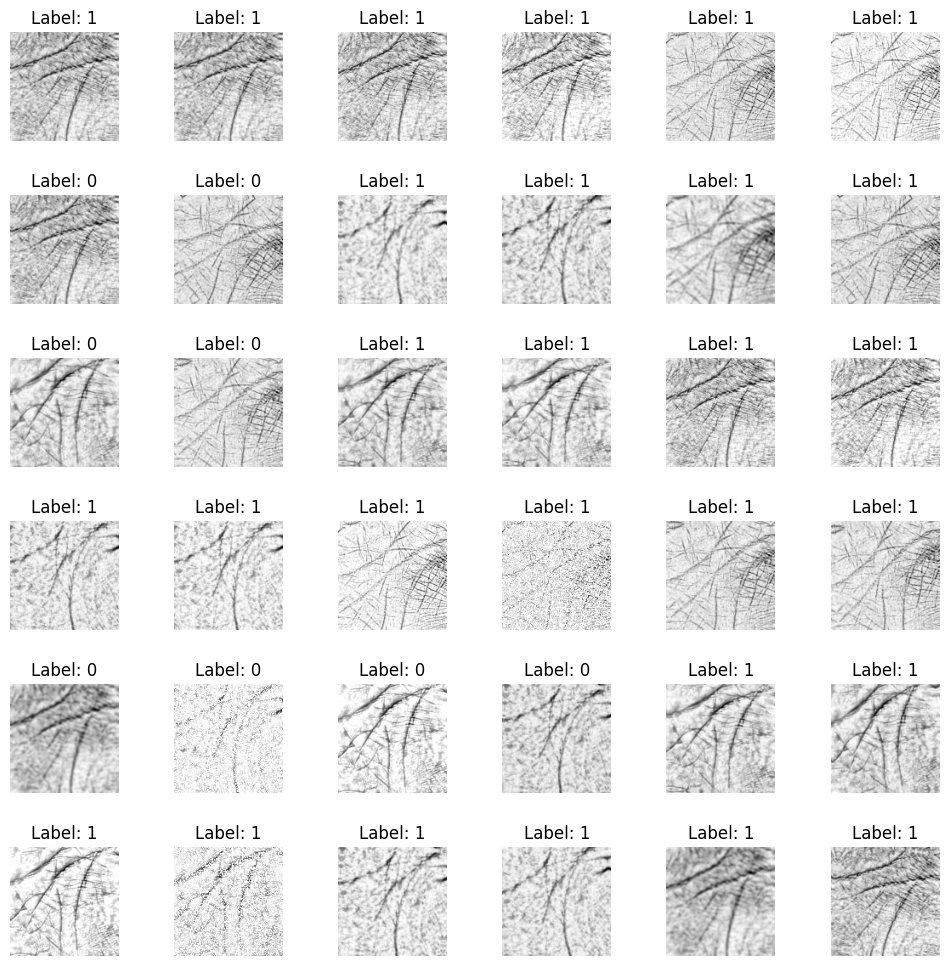

In [16]:
# plot into grid image pairs and labels for visualization
import matplotlib.pyplot as plt

# make the grid to visualize the image pairs

fig, ax = plt.subplots(6, 6, figsize=(12, 12))
counter = 0
for i in range(6):
    for j in range(0, 6, 2):
        img1 = train_pairs[counter][0]
        img2 = train_pairs[counter][1]
        label = train_labels[counter]

        ax[i, j].imshow(img1.squeeze(), cmap='gray')
        ax[i, j].set_title(f'Label: {label}')
        ax[i, j].axis('off')

        ax[i, j+1].imshow(img2.squeeze(), cmap='gray')
        ax[i, j+1].set_title(f'Label: {label}')
        ax[i, j+1].axis('off')

        counter += 1

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


# CATATAN: pasangan data adalah index 0 dan 1, 2 dan 3, 4 dan 5, dst. dari kiri ke kanan lalu ke bawah

In [17]:
# Siamese model
base_model, learning_rate_reduction = build_siamese_model(input_shape)

In [18]:
# Two inputs for the model
input_A = Input(shape=input_shape)
input_B = Input(shape=input_shape)

In [19]:
# Generate embeddings for both inputs
embedding_A = base_model(input_A)
embedding_B = base_model(input_B)

In [20]:
# Calculate distance between embeddings
distance = Lambda(euclidean_distance)([embedding_A, embedding_B])

In [21]:
# Build the final model
siamese_model = Model(inputs=[input_A, input_B], outputs=distance)

In [22]:
# Compile the model
siamese_model.compile(
    loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=[accuracy]
)

In [23]:
# Prepare the data
X_train = [train_pairs[:, 0], train_pairs[:, 1]]
X_test = [test_pairs[:, 0], test_pairs[:, 1]]
y_train = train_labels.astype('float32')
y_test = test_labels.astype('float32')


In [24]:
print("X Train Shape: ", X_train[0].shape, X_train[1].shape)
print("X Train Example Data:" , X_train[0][0], X_train[1][0])

X Train Shape:  (140, 128, 128, 1) (140, 128, 128, 1)
X Train Example Data: [[[0.7372549 ]
  [0.7529412 ]
  [0.74509805]
  ...
  [0.78039217]
  [0.7647059 ]
  [0.7411765 ]]

 [[0.70980394]
  [0.7490196 ]
  [0.7372549 ]
  ...
  [0.38431373]
  [0.45490196]
  [0.54509807]]

 [[0.75686276]
  [0.7921569 ]
  [0.73333335]
  ...
  [0.40392157]
  [0.39607844]
  [0.49411765]]

 ...

 [[0.8666667 ]
  [0.8509804 ]
  [0.79607844]
  ...
  [0.7490196 ]
  [0.78039217]
  [0.7607843 ]]

 [[0.8509804 ]
  [0.84705883]
  [0.8235294 ]
  ...
  [0.77254903]
  [0.83137256]
  [0.827451  ]]

 [[0.81960785]
  [0.827451  ]
  [0.80784315]
  ...
  [0.74509805]
  [0.7647059 ]
  [0.7607843 ]]] [[[0.83137256]
  [0.84705883]
  [0.8392157 ]
  ...
  [0.8745098 ]
  [0.85882354]
  [0.8352941 ]]

 [[0.8039216 ]
  [0.84313726]
  [0.83137256]
  ...
  [0.47843137]
  [0.54901963]
  [0.6392157 ]]

 [[0.8509804 ]
  [0.8862745 ]
  [0.827451  ]
  ...
  [0.49803922]
  [0.49019608]
  [0.5882353 ]]

 ...

 [[0.9607843 ]
  [0.94509804]


In [25]:
# Melatih model dengan callback
history = siamese_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[learning_rate_reduction]  # Memasukkan callback di sini
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 830ms/step - accuracy: 0.5265 - loss: 0.5562 - val_accuracy: 0.5000 - val_loss: 0.4583 - learning_rate: 0.0100
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5558 - loss: 0.3325 - val_accuracy: 0.5000 - val_loss: 0.4014 - learning_rate: 0.0100
Epoch 3/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5469 - loss: 0.3112
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5460 - loss: 0.3154 - val_accuracy: 0.4938 - val_loss: 0.3574 - learning_rate: 0.0100
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4989 - loss: 0.1980 - val_accuracy: 0.5000 - val_loss: 0.4128 - learning_rate: 0.0070
Epoch 5/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5530 - loss: 0.1630
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004899999825283885.
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5516 - loss: 0.1643 - val_accur

In [26]:
val = siamese_model.evaluate(X_test, y_test)

print("\n ================= Evaluation : Xception model ================= \n")
print("  Results : \n")
print("Loss  : %.2f" % (val[0]))
print("Score : %.2f%%" % (val[1] * 100))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5469 - loss: 0.0052

 ================= Evaluation : Xception model ================= 

  Results : 

Loss  : 0.01
Score : 56.64%


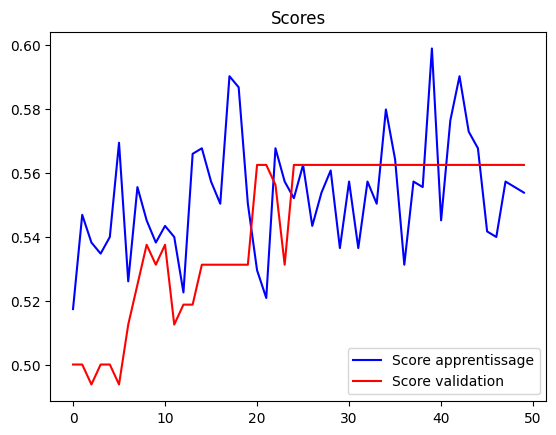

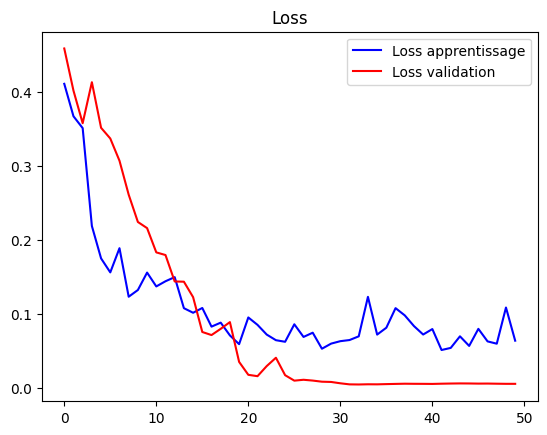

In [27]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_scores(history)
plot_loss(history)

In [ ]:
'''# Save the trained model
# siamese_model.save('palmID_siamese_model.h5')

model_json = siamese_model.to_json()
#.json is the architecture
with open("palmID_siamese_model.json", "w") as json_file:
    json_file.write(model_json)
#.h5 is the weights of the model
siamese_model.save('palmID_siamese_model.h5')'''

In [ ]:
'''siamese_model.load_weights('palmID_siamese_model.h5')'''